# Simulating DSA-200 Images (RCP-like output)

From tyrones_stuff, simulate a very large image, e.g.:

`python sky_model.py --first ~/catalogs/first/first_14dec17.fits -o test_first.fits`

or as Viviana did it:

`python sky_model.py  --agn /safepool/vrosero/TRECs/catalogs/trecs/wide/catalogue_AGNs_complete_wide.fits --sfg "/safepool/vrosero/TRECs/catalogs/trecs/wide/catalogue_SFGs_complete_wide1.fits,/safepool/vrosero/TRECs/catalogs/trecs/wide/catalogue_SFGs_complete_wide2.fits,/safepool/vrosero/TRECs/catalogs/trecs/wide/catalogue_SFGs_complete_wide3.fits,/safepool/vrosero/TRECs/catalogs/trecs/wide/catalogue_SFGs_complete_wide4.fits,/safepool/vrosero/TRECs/catalogs/trecs/wide/catalogue_SFGs_complete_wide5.fits,/safepool/vrosero/TRECs/catalogs/trecs/wide/catalogue_SFGs_complete_wide6.fits,/safepool/vrosero/TRECs/catalogs/trecs/wide/catalogue_SFGs_complete_wide7.fits,/safepool/vrosero/TRECs/catalogs/trecs/wide/catalogue_SFGs_complete_wide8.fits,/safepool/vrosero/TRECs/catalogs/trecs/wide/catalogue_SFGs_complete_wide9.fits,/safepool/vrosero/TRECs/catalogs/trecs/wide/catalogue_SFGs_complete_wide10.fits" -o /safepool/vrosero/TRECs/images/dsa2k_first+trecsagnsfg_8192.fits  --target 0 0 1 1`

Details at https://github.com/Radio-Camera-Initiative/tyrones_stuff/blob/main/SURF_2021_Final_Report_v3.pdf.

TODO: add more sources and make larger area. be sure to set npix to produce correct pixel scale

The simulation process will apply image-plane modifications as they are applied by propagation and measurement (going "forward").
1. apply ionospheric screen
2. apply primary beam and cut out 16k x 16k field (~10 sq deg)
3. add noise
4. convolve with PSF

Then iterate over new screens and pointing directions to create a sequence of measurements of a "tile" (e.g., 5x5).a

## Setup

In [1]:
import os.path
from scipy.interpolate import RBFInterpolator, CloughTocher2DInterpolator
from multiprocess import Pool
from typing import Literal, Tuple, Union
from astropy.coordinates import SkyCoord
from astropy import units as u
import astropy.wcs as wcs
from astropy.io import fits

import numpy as np
from jax.scipy.signal import convolve
import jax.numpy as jnp
from jaxtyping import Array
import pandas as pd

In [2]:
from data import fits_image
from flow import Flow
from util import indices, rescale_quantile, gaussian_filter, match_histograms
from interactive import toggle_images, plot_image, sequence_images

import cv2

In [3]:
def compute_offsets(dxmodel, dymodel):
    # compute each row separately
    def calc_row(r):
        # all indices with row r
        xy =  np.indices((1, IMAGE_SIZE)).squeeze().transpose()  
        xy[:, 0] = r
        row_offsets = np.stack((dxmodel(xy), dymodel(xy)), axis=-1)
        return row_offsets
    
    # Naive multiprocessing (computing each row separately):
    # Note: while this should be extremely parallelizable , something (likely the GIL)
    # is preventing us from achieving optimal performance. This seems to take about 3
    # minutes with multiprocessing (64 cores) and 4.5 minutes without. Thus, Amdahl's
    # law tells us that only about 25% of this task is parallelizable (though it
    # should be closer to 100%).
    def go():
        res = None
        with Pool(processes=CPU_COUNT) as p:
            try:
                res = p.map(calc_row, list(range(IMAGE_SIZE)))
            except:
                p.close()
                import traceback
                raise Exception("".join(traceback.format_exception(*sys.exc_info())))
        return res

    results = go()
    return np.concatenate(results)

def compute_interpolation(interp):
    def g(r):
        xy =  np.indices((1, IMAGE_SIZE)).squeeze().transpose()
        xy[:, 0] = r
        return interp(xy)
    
    # naive multiprocessing, see above
    def go():
        res = None
        with Pool(processes=CPU_COUNT) as p:
            try:
                res = p.map(g, list(range(IMAGE_SIZE)))
            except:
                p.close()
                import traceback
                raise Exception("".join(traceback.format_exception(*sys.exc_info())))
                
        return res

    results = go()
    interp_img = np.stack(results, axis=0)
    return interp_img


In [4]:
def reference_sources_nvss(catalog, min_flux=270) -> Tuple[SkyCoord, Array]:
    nvss = pd.read_csv(catalog, sep=r"\s+")
    sorted_nvss = nvss.sort_values(by=["f"])

    # cut off refernce sources below a certain flux density
    sorted_nvss = sorted_nvss[sorted_nvss["f"] >= min_flux]

    # get coordinates of each reference source
    nvss_orig = sorted_nvss[["rah", "ram", "ras", "dd", "dm", "ds"]].to_numpy()

    # get flux of each reference source in Jy
    fluxes = sorted_nvss[["f"]].to_numpy().squeeze() / 1000

    # manually convert HMS:DMS into degrees
    nvss_ra = (
        15 * nvss_orig[:, 0]
        + (15 / 60) * nvss_orig[:, 1]
        + (15 / 3600) * nvss_orig[:, 2]
    )
    nvss_dec = (
        nvss_orig[:, 3] + (1 / 60) * nvss_orig[:, 4] + (1 / 3600) * nvss_orig[:, 5]
    )

    positions = np.stack((nvss_ra, nvss_dec), axis=-1)

    return SkyCoord(positions, unit=(u.deg, u.deg)), jnp.array(fluxes)

In [5]:
def gkern(l=5, sig=1.0):
    """\
    Creates gaussian kernel with side length `l` and a sigma of `sig`.
    Reaches a maximum of 1 at its center value
    """
    ax = jnp.linspace(-(l - 1) / 2.0, (l - 1) / 2.0, l)
    gauss = jnp.exp(-0.5 * jnp.square(ax) / jnp.square(sig))
    kernel = jnp.outer(gauss, gauss)
    return kernel / kernel.max()

In [6]:
def pbcut(img, center, size):
    """ Multiple by Gaussian primary beam at location center (in (x,y) pixel coords) and width size (pixels).
    center and size in units of pixels
    """
    pb_kernel = gkern(size, size/4)  # TODO figure out width
    return np.array(img[(center[1]-size//2):(center[1]+size//2), (center[0]-size//2):(center[0]+size//2)]*pb_kernel)

def pbmult(img, center, width):
    """ Multiply img by Gaussian primary beam centered at center with width and return entire image.
    width in units of pixels
    """
    size = len(img)
    pb_kernel = gkern(2*size, size/4)  # TODO figure out width
    return img*pb_kernel[size-center[1]:2*size-center[1], size-center[0]:2*size-center[0]]

In [7]:
import astropy.coordinates as ac
import astropy.units as au
import numpy as np
import pylab as plt


def fibonacci_celestial_sphere(n: int) -> ac.ICRS:
    """
    Generates 'n' points on the surface of a sphere using the Fibonacci sphere algorithm.

    Args:
        n (int): Number of points to generate.

    Returns:
        lon (jnp.ndarray): Array of longitudes in radians.
        lat (jnp.ndarray): Array of latitudes in radians.
    """
    # Golden angle in radians
    golden_angle = np.pi * (3.0 - np.sqrt(5.0))  # Approximately 2.39996 radians

    # Indices from 0 to n-1
    indices = np.arange(n)

    # Compute y coordinates (latitude component)
    y = 1 - (2 * indices) / (n - 1)  # y ranges from 1 to -1

    # Compute latitude in radians
    lat = np.arcsin(y)

    # Compute longitude in radians
    theta = golden_angle * indices
    lon = theta % (2 * np.pi)  # Ensure longitude is within [0, 2π)

    return ac.ICRS(lon * au.rad, lat * au.rad)

## 1. Apply primary beam

In [8]:
# Details on simulation at https://github.com/Radio-Camera-Initiative/tyrones_stuff/blob/main/SURF_2021_Final_Report_v3.pdf
#input_image = '/home/claw/code/tyrones_stuff/test_first_2048.fits'  # toy image at 1350 MHz and FIRST catalog
input_image = '/fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_vrosero.fits'

# actual:
# - 5x5 field hexagonal mosaic
# - separations should scale with PB FWHM of 3.06 deg (at 1.35 GHz) (Jonas has model with HWHM~1.125 at 2 GHz)
# - 2 deg center-to-center separation (2/3 of PB FWHM) with equilateral triangle separations
# - mosaic should cover 1x field width outside edge

In [9]:
image, imwcs = fits_image(input_image)
IMAGE_SIZE = image.shape[0]
pixelscale = 1*3600/IMAGE_SIZE  # arcsec/pixel
CPU_COUNT = 16
WORKING_DIR = '/fastpool/claw/images/'
print(f'Image size: {IMAGE_SIZE} and scale {pixelscale}"/pixel')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Image size: 8196 and scale 0.43923865300146414"/pixel


In [10]:
# From Josh: fibonacci_celestial_sphere(n=9000)
# Produces set of pointings wtih typical separation of 2.0 deg (2/3 of FWHM)
# Here are central 25 pointings (all within 6 deg of (RA, Dec) = (0, 0)) in units of degrees

pts_all = fibonacci_celestial_sphere(n=50000)
center = ac.SkyCoord(0, 0, unit="deg")
image, w0 = fits_image(input_image)

In [11]:
pts = []
fields = {}
for i in range(len(pts_all)):
    if pts_all[i].separation(center).value < 6:
        x, y = w0.all_world2pix(pts_all[i].ra.value, pts_all[i].dec.value, 1)
        if (x > 0) and (y > 0) and (x < IMAGE_SIZE) and (y < IMAGE_SIZE):
            print(x,y)
            fields[input_image.replace(".fits", f"_sub{i}.fits")] = (int(x), int(y))

328.3622359442174 6849.66065893425
5991.411562004764 2472.816391732746


In [12]:
fields

{'/fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_vrosero_sub24853.fits': (328,
  6849),
 '/fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_vrosero_sub25086.fits': (5991,
  2472)}

In [15]:
# read simulated primary beam
import h5py

In [55]:
file_path = '/fastpool/claw/images/DSA2000-beam-wShieldSolidCylinder600mm.h5'
with h5py.File(file_path, 'r') as f:
    freq_Hz = f['freq_Hz'][:]
    theta_pts = f['theta_pts'][:]
    phi_pts = f['phi_pts'][:]
    
    # X polarization E-fields
    X_pol_etheta = f['X_pol_Efields/etheta'][:]
    X_pol_ephi = f['X_pol_Efields/ephi'][:]
    
    # Y polarization E-fields
    Y_pol_etheta = f['Y_pol_Efields/etheta'][:]
    Y_pol_ephi = f['Y_pol_Efields/ephi'][:]
    
    # Freq idx for 1.35 GHz
    freq_idx = 1
    selected_freq = freq_Hz[freq_idx]
    
    # Compute the total E-field for X and Y polarizations
    E_tot_X = np.abs(X_pol_etheta[freq_idx, :, :])**2 + np.abs(X_pol_ephi[freq_idx, :, :])**2
    E_tot_Y = np.abs(Y_pol_etheta[freq_idx, :, :])**2 + np.abs(Y_pol_ephi[freq_idx, :, :])**2

theta_radians = np.deg2rad(theta_pts)
phi_radians = np.deg2rad(phi_pts)

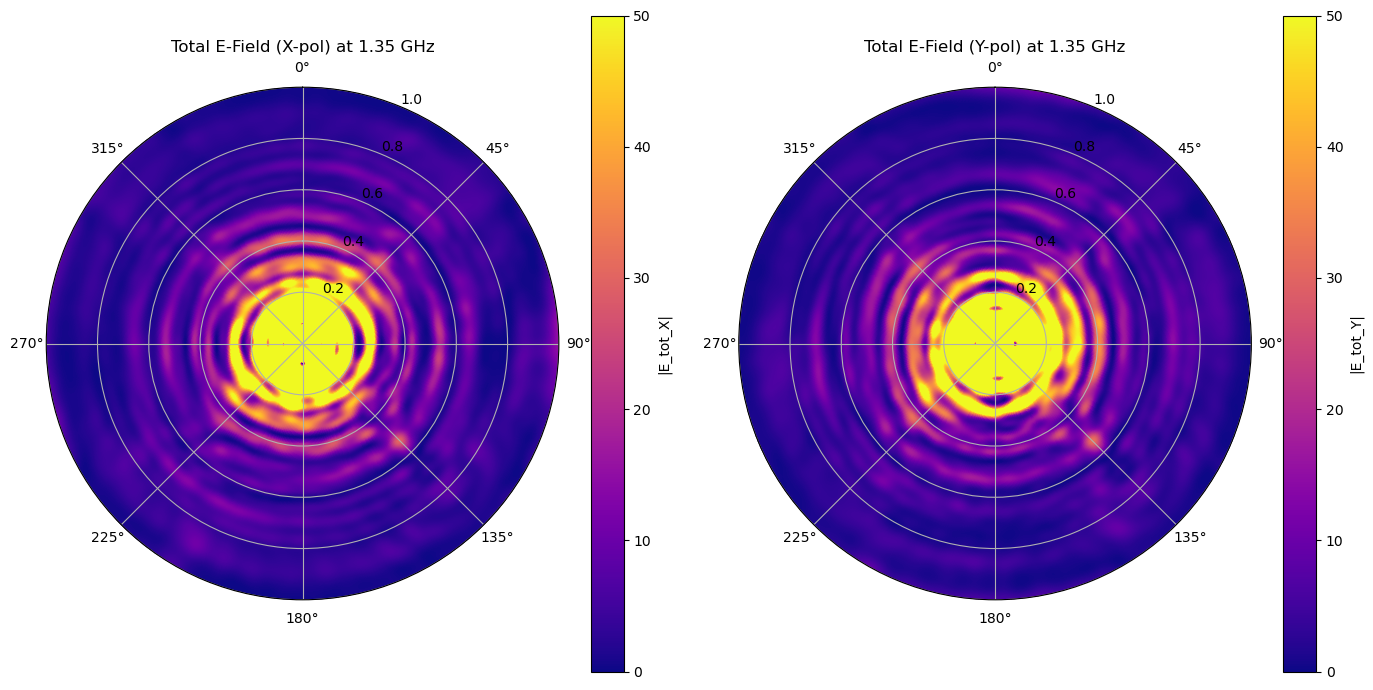

In [58]:
Theta, Phi = np.meshgrid(theta_radians, phi_radians)

fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(14, 7))

c1 = ax1.pcolormesh(Phi, Theta, E_tot_X.T, vmin = 0, vmax = 50, shading='auto', cmap='plasma')
ax1.set_title(f'Total E-Field (X-pol) at {selected_freq} GHz')
ax1.set_theta_zero_location('N')  # Set 0 degrees at the top
ax1.set_theta_direction(-1)  # Set angles to increase clockwise
fig.colorbar(c1, ax=ax1, label='|E_tot_X|')

# Zoom in on theta
ax1.set_ylim(0, 1.)

# Plot for Y polarization in polar coordinates
c2 = ax2.pcolormesh(Phi, Theta, E_tot_Y.T, vmin = 0, vmax = 50, shading='auto', cmap='plasma')
ax2.set_title(f'Total E-Field (Y-pol) at {selected_freq} GHz')
ax2.set_theta_zero_location('N')  # Set 0 degrees at the top
ax2.set_theta_direction(-1)  # Set angles to increase clockwise
fig.colorbar(c2, ax=ax2, label='|E_tot_Y|')

# Zoom in on theta
ax2.set_ylim(0, 1.)

plt.tight_layout()
plt.savefig('/fastpool/claw/images/DSA2000-beam-wShieldSolidCylinder600mm.png')

In [170]:
X, Y = np.radians(np.mgrid[0:1:0.01]), np.radians(np.mgrid[0:1:0.01])

In [171]:
def cartesian_to_polar(x, y):
    phi = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return phi, theta

def find_nearest_index(array, value):
    nearest_index = min(range(len(array)), key=lambda i: abs(array[i] - value))
    return nearest_index

In [172]:
T0, P0 = cartesian_to_polar(X, Y)

In [174]:
im = np.zeros( (100, 100) )
for i in range(len(T0)):
    for j in range(len(P0)):
        it, ip = find_nearest_index(Theta[0], T0[i]), find_nearest_index(Phi[:, 0], P0[j])
        im[i, j] = E_tot_X.T[it, ip]

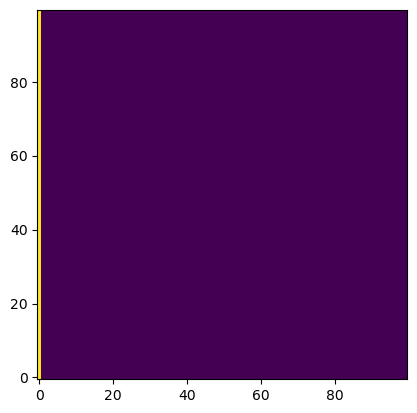

In [175]:
plt.imshow(im, origin='lower')

In [57]:
overwrite = False
width = 1800  # arcsec

wcss = fields.copy()

for name, center in fields.items():
    if not overwrite and os.path.exists(os.path.join(WORKING_DIR, name)):
        print(f'not overwriting {name}')
        continue

    print(os.path.join(WORKING_DIR, name))
    image, w0 = fits_image(input_image)
    output_pbcut = np.array(pbmult(image, center, int(width/pixelscale)))
#    output_image = np.expand_dims(np.expand_dims(output_pbcut, 0), 0)

#    crval = w0.pixel_to_world(center[0], center[1])
#    w0.wcs.crval = [crval.ra.value, crval.dec.value]
#    w0.wcs.crpix = [int(width/pixelscale)//2, int(width/pixelscale)//2]
    hdr = w0.to_header()     # TODO: modified wcs to cutout region
    wcss[name] = w0
    fits.writeto(f"{os.path.join(WORKING_DIR, name)}", output_pbcut, header=hdr, overwrite=overwrite)

not overwriting /fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_vrosero_sub24853.fits
not overwriting /fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_vrosero_sub25086.fits


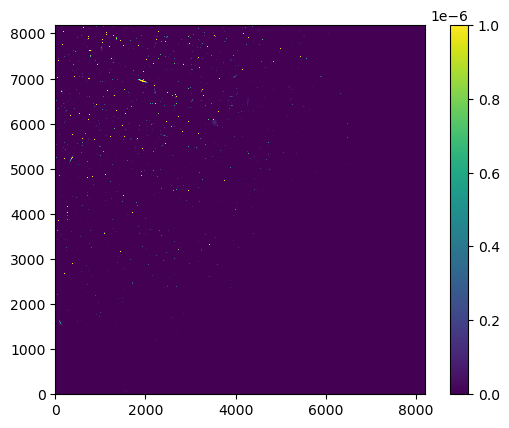

In [27]:
im = fits.open(list(fields.keys())[0])[0].data.squeeze()
plot_image(im, vmin=im.min(), vmax=1e-6)

## 2. Ionosphere (one per field)

## fake a warp screen with random ~PSF scale shifts at NVSS positions


In [28]:
# potential improvement:
# Josh says ionosphere should show coherent shifts across 0.6deg scales
# Neighboring 0.6deg regions being independent (a sequence of fields have independent screens)
# NVSS is 2 mJy sky => 40/deg2 => roughly 1 per 10 arcmin
# Simulated screen is smoothed, so maybe 1/10 arcmin is lower limit and actual screen is likely close to physical value.

In [29]:
catalog = '/fastpool/claw/catalogs/nvss_trim.dat'

In [30]:
positions_xys = fields.copy()

for name, positions_xy in positions_xys.items():
    print(name)
    hdu = fits.open(f"{os.path.join(WORKING_DIR, name)}")[0]
    w = wcs.WCS(header=hdu.header)
    positions, fluxes = reference_sources_nvss(catalog=catalog)
    positions_xy = jnp.stack(wcs.utils.skycoord_to_pixel(positions, w), axis=1)
    fluxes = fluxes[~jnp.isnan(positions_xy).any(axis=1)]
    positions_xys[name] = positions_xy[~jnp.isnan(positions_xy).any(axis=1)]

/fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_vrosero_sub24853.fits
/fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_vrosero_sub25086.fits


In [33]:
smoothing = 200
neighbors = 3
max_shift = 2
overwrite = False

for name, positions_xy in positions_xys.items():
    if not overwrite and os.path.exists(os.path.join(WORKING_DIR, name.replace('.fits', 'warped.fits'))):
        print('\tnot overwriting', name.replace('.fits', 'warped.fits'))
        continue
    print(name.replace('.fits', 'warped.fits'))

    hdu = fits.open(f"{os.path.join(WORKING_DIR, name)}")[0]
    image = hdu.data
    hdr = hdu.header
    IMAGE_SIZE = image.shape[0]
    
    # create difference array
    diff = np.random.randint(-max_shift, max_shift+1, size=(len(positions_xy), 2))   
    dxmodel = RBFInterpolator(positions_xy, diff[:, 0], kernel='linear', smoothing=smoothing, neighbors=neighbors)
    dymodel = RBFInterpolator(positions_xy, diff[:, 1], kernel='linear', smoothing=smoothing, neighbors=neighbors)
    offsets = compute_offsets(dxmodel, dymodel).reshape(IMAGE_SIZE, IMAGE_SIZE, 2)  # IMAGE_SIZE^2 x 2
    print('calculating flow')
    fl = Flow(offsets=offsets)
    output_img = fl.apply(np.float_(image))

    bmaj = 3.3*u.arcsec
    hdr['BUNIT'] = 'Jy/beam'
    hdr['BTYPE'] = 'Intensity'
    hdr['BMAJ'] = bmaj.to(u.deg).value
    hdr['BMIN'] = bmaj.to(u.deg).value
    hdr['BPA'] = 0.0
            
    plot_image(output_img.squeeze(), vmax=1e-5)
    fits.writeto(os.path.join(WORKING_DIR, name.replace('.fits', 'warped.fits')), output_img, header=hdr, overwrite=overwrite)

	not overwriting /fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_vrosero_sub24853warped.fits
	not overwriting /fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_vrosero_sub25086warped.fits


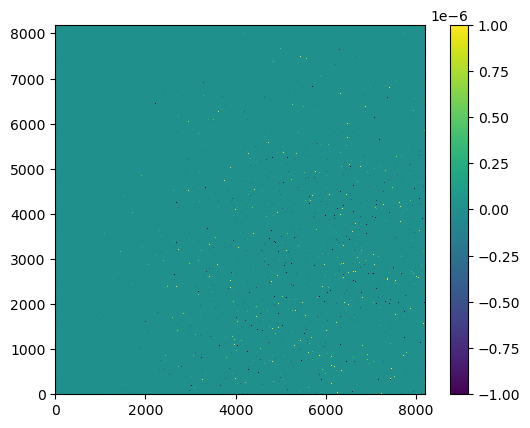

In [37]:
plot_image((np.float_(image)-output_img.squeeze()), vmin=-1e-6, vmax=1e-6)

## 3. Make PSF per field

In [38]:
# rotate PSF per field? scipy affine transform (effects of changing projected size and orientation of array)
# save PSF per field

In [39]:
psf_filename = '/fastpool/data/W-GC-8000chan-briggs09-psf.fits'
psf_image, psf_wcs = fits_image(psf_filename)
rows, cols = psf_image.shape

making W-GC-8000chan-briggs09-psf_sub24853.fits


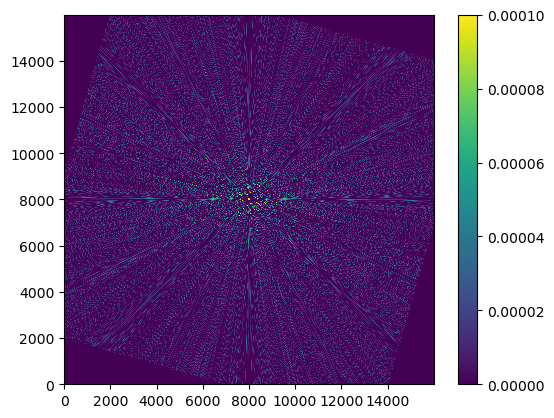

making W-GC-8000chan-briggs09-psf_sub25086.fits


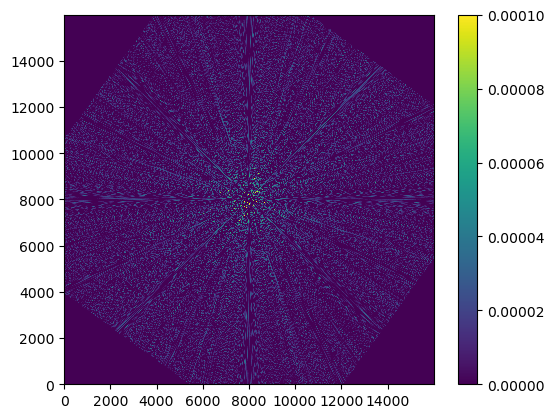

In [40]:
overwrite = True

psfs = {}
for name, center in fields.items():
    suffix = '_' + name.split('_')[-1]
    newname = os.path.basename(psf_filename).replace('.fits', suffix)
    if not overwrite and os.path.exists(os.path.join(WORKING_DIR, newname)):
        print(f'skipping {newname}')
        continue
    else:
        print(f'making {newname}')

    angle = np.random.randint(180) # deg
    scale = np.random.uniform(1, 2) # foreshortening factor from ZA=0-60 deg

    dst = cv2.resize(np.array(psf_image), (int(scale*cols), rows))[:, int((scale-1)*cols)//2:int((scale+1)*cols)//2]   # rescale
    midx, midy = np.where(dst == dst.max())
    M = cv2.getRotationMatrix2D((int(midx[0]), int(midy[0])), angle, 1)
    cols, rows = dst.shape
    dst = cv2.warpAffine(dst, M, (cols, rows))  # rotate
    plot_image(dst, vmax=1e-4)
    psfs[name] = newname
    fits.writeto(os.path.join(WORKING_DIR, newname), dst, header=psf_wcs.to_header(), overwrite=overwrite)

## 4. Add noise and convolve

/fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_vrosero_sub24853.fits


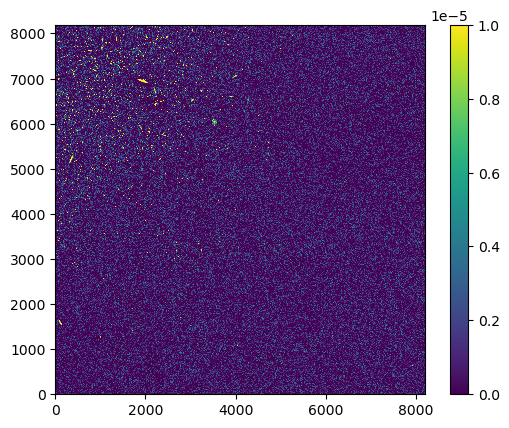

/fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_vrosero_sub25086.fits


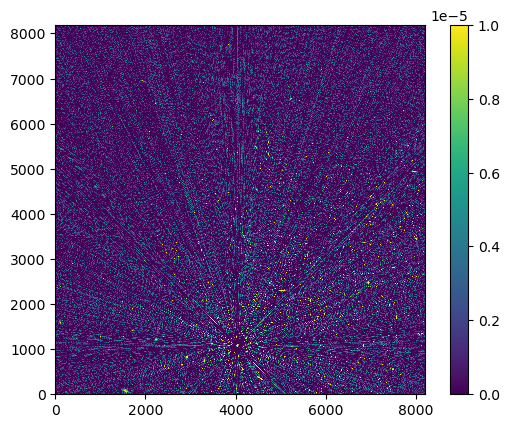

In [41]:
noise_sigma = 3e-7  # noise floor is 6x higher in Jy/beam
realbeam = True
overwrite = True

for name, positions_xy in positions_xys.items():
    if not overwrite and os.path.exists(os.path.join(WORKING_DIR, name.replace('.fits', 'warpednoiseconv.fits'))):
        print('\tskipping', name)
        continue
    print(name)

    if realbeam:
        psf_filename = psfs[name]  # '/fastpool/data/W-GC-8000chan-briggs09-psf.fits'
        psf_image, psf_wcs = fits_image(os.path.join(WORKING_DIR, psf_filename))
        hdr = psf_wcs.to_header()

        # normalization factor for core of PSF that overlaps input image
#        psf_width = psf_image.squeeze().shape[0]
#        psf_norm = psf_image.squeeze()[psf_width//2-IMAGE_SIZE//2:psf_width//2+IMAGE_SIZE//2,
#                                       psf_width//2-IMAGE_SIZE//2:psf_width//2+IMAGE_SIZE//2].sum()

#        print(psf_norm, psf_width, IMAGE_SIZE)
    else:
        # overload with restoring beam
        psf_image = gkern(l=64, sig=3.3/pixelscale)
#        psf_norm = psf_image.sum()

    hdu = fits.open(name.replace('.fits', 'warped.fits'))[0]
    image = np.ma.masked_invalid(hdu.data.squeeze())
    image.set_fill_value(0)
    hdr = hdu.header
    noise = np.random.normal(0, noise_sigma, size=image.shape)  # zero mean
    image_noise = image.filled()+noise
    noise_convolved = convolve(image_noise, psf_image, mode="same", method="fft")

    bmaj = 3.3*u.arcsec
    hdr['BUNIT'] = 'Jy/beam'
    hdr['BTYPE'] = 'Intensity'
    hdr['BMAJ'] = bmaj.to(u.deg).value
    hdr['BMIN'] = bmaj.to(u.deg).value
    hdr['BPA'] = 0.0
            
    noise_convolved = np.array(noise_convolved)
    fits.writeto(os.path.join(WORKING_DIR, name.replace('.fits', 'warpednoiseconv.fits')), noise_convolved, header=hdr, overwrite=overwrite)
    plot_image(noise_convolved, vmax=1e-5)

## 5. cut (and optionally rescale)

In [106]:
#for name, center in fields.items():
#    if not overwrite and os.path.exists(os.path.join(WORKING_DIR, name)):
#        print(f'not overwriting {name}')
#        continue
#    image, w0 = fits_image(input_image)
#    output_pbcut = image[center[1]-size//2:center[1]+size//2, center[0]-size//2:center[0]+size//2]  # TODO check that this cuts out as before

#    crval = w0.pixel_to_world(center[0], center[1])
#    w0.wcs.crval = [crval.ra.value, crval.dec.value]
#    w0.wcs.crpix = [int(width/pixelscale)//2, int(width/pixelscale)//2]
#    hdr = w0.to_header()     # TODO: modified wcs to cutout region
#    wcss[name] = w0
#    fits.writeto(f"{os.path.join(WORKING_DIR, name)}", output_pbcut, header=hdr, overwrite=overwrite)

# img1r = rescale_quantile(img1, 0.5, 0.95)